In [1]:
from astropy.io import fits
from astropy import wcs
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.table import Table
import astropy.constants as c
from extinction import apply
import extinction

In [2]:
cat770 = Table.read('/orange/adamginsburg/jwst/sgrb2/NB/pipeline_reruns/MIRI_for_catalogs_try2/jw05365-o002_t002_miri_f770w_cat.fits')
cat1280 = Table.read('/orange/adamginsburg/jwst/sgrb2/NB/pipeline_reruns/MIRI_for_catalogs_try2/jw05365-o002_t002_miri_f1280w_cat.fits')
cat2550 = Table.read('/orange/adamginsburg/jwst/sgrb2/NB/pipeline_reruns/MIRI_for_catalogs_try2/jw05365-o002_t002_miri_f2550w_cat.fits')    

In [ ]:


search_radius = 0.25 * u.arcsec

def match_catalog(ref_coords, other_coords, radius):
    idx, sep2d, _ = ref_coords.match_to_catalog_sky(other_coords)
    matched = np.full(len(ref_coords), np.nan)  
    mask = sep2d <= radius
    matched[mask] = idx[mask]
    return matched

sc770 = cat770['sky_centroid']
sc1280 = cat1280['sky_centroid']
sc2550 = cat2550['sky_centroid']

match1280 = match_catalog(sc770, sc1280, search_radius)
match2550 = match_catalog(sc770, sc2550, search_radius)

combined = Table()

for col in cat770.colnames:
    combined[col + '770'] = cat770[col]


def add_matched_columns(base_cat, match_idx, suffix):
    for col in base_cat.colnames:
        if isinstance(base_cat[col][0], SkyCoord):
            empty_coords = SkyCoord(
                ra=[np.nan]*len(match_idx)*u.deg,
                dec=[np.nan]*len(match_idx)*u.deg,
                frame=base_cat[col].frame.name
            )
            for j, idx in enumerate(match_idx):
                if not np.isnan(idx):
                    empty_coords[j] = base_cat[col][int(idx)]
            combined[col + suffix] = empty_coords
        else:
           
            arr = np.full(len(match_idx), np.nan)
            for j, idx in enumerate(match_idx):
                if not np.isnan(idx):
                    arr[j] = base_cat[col][int(idx)]
            combined[col + suffix] = arr


add_matched_columns(cat1280, match1280, '1280')
add_matched_columns(cat2550, match2550, '2550')


/scratch/local/9533911/ipykernel_3433083/2652775439.py:42: UserWarning: Warning: converting a masked element to nan.
  arr[j] = base_cat[col][int(idx)]


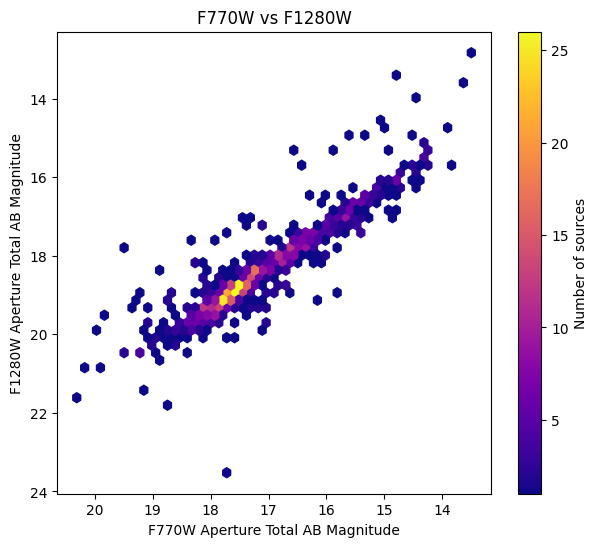

In [ ]:
import matplotlib.pyplot as plt

x = combined['aper_total_abmag770']
y = combined['aper_total_abmag1280']

plt.figure(figsize=(7, 6))
hb = plt.hexbin(
    x, y,
    gridsize=50,        
    cmap='plasma',
    mincnt=1           
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(hb, label='Number of sources')
plt.xlabel('F770W Aperture Total AB Magnitude')
plt.ylabel('F1280W Aperture Total AB Magnitude')
plt.title('F770W vs F1280W')
plt.show()


In [5]:
cat = Table.read('/orange/adamginsburg/jwst/sgrb2/NB/catalogs/crowdsource_nsky0_merged_photometry_tables_merged.fits')
cat11 = Table.read('/orange/adamginsburg/jwst/sgrb2/NB/crowdsource_nsky0_merged_photometry_tables_merged_11matches.fits')

In [ ]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

# Parameters
ra_shift_arcsec = 0.09
dec_shift_arcsec = 0.085
match_radius = 0.2 * u.arcsec


ra_shift_deg = ra_shift_arcsec / 3600.0
dec_shift_deg = dec_shift_arcsec / 3600.0


combined_shifted_coords = SkyCoord(
    ra = combined['sky_centroid770'].ra.deg + ra_shift_deg,
    dec = combined['sky_centroid770'].dec.deg + dec_shift_deg,
    unit='deg'
)


cat_coords = cat['skycoord_ref']


idx, sep2d, _ = combined_shifted_coords.match_to_catalog_sky(cat_coords)

match_mask = sep2d < match_radius

new_cat = combined.copy()

for col in cat.colnames:
    if col in new_cat.colnames:
        new_name = col + "_cat"
    else:
        new_name = col


    if isinstance(cat[col], SkyCoord):
        new_data_ra = np.full(len(new_cat), np.nan)
        new_data_dec = np.full(len(new_cat), np.nan)
        new_data_ra[match_mask] = cat[col][idx[match_mask]].ra.deg
        new_data_dec[match_mask] = cat[col][idx[match_mask]].dec.deg
        new_cat[new_name + "_ra"] = new_data_ra
        new_cat[new_name + "_dec"] = new_data_dec
        continue


    dtype = cat[col].dtype
    if np.issubdtype(dtype, np.number):
        fill_val = np.nan
    else:
        fill_val = None

    new_data = np.full(len(new_cat), fill_val, dtype=dtype)
    new_data[match_mask] = cat[col][idx[match_mask]]
    new_cat[new_name] = new_data

new_cat['match_sep_arcsec'] = sep2d.to(u.arcsec)


/blue/adamginsburg/nbudaiev/python_env/JWST_SgrB2/lib/python3.12/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [7]:
new_cat[0]

label770,xcentroid770,ycentroid770,sky_centroid770,aper_bkg_flux770,aper_bkg_flux_err770,aper30_flux770,aper30_flux_err770,aper50_flux770,aper50_flux_err770,aper70_flux770,aper70_flux_err770,aper_total_flux770,aper_total_flux_err770,aper30_abmag770,aper30_abmag_err770,aper50_abmag770,aper50_abmag_err770,aper70_abmag770,aper70_abmag_err770,aper_total_abmag770,aper_total_abmag_err770,aper30_vegamag770,aper30_vegamag_err770,aper50_vegamag770,aper50_vegamag_err770,aper70_vegamag770,aper70_vegamag_err770,aper_total_vegamag770,aper_total_vegamag_err770,CI_50_30770,CI_70_50770,CI_70_30770,is_extended770,sharpness770,roundness770,nn_label770,nn_dist770,isophotal_flux770,isophotal_flux_err770,isophotal_abmag770,isophotal_abmag_err770,isophotal_vegamag770,isophotal_vegamag_err770,isophotal_area770,semimajor_sigma770,semiminor_sigma770,ellipticity770,orientation770,sky_orientation770,sky_bbox_ll770,sky_bbox_ul770,sky_bbox_lr770,sky_bbox_ur770,label1280,xcentroid1280,ycentroid1280,sky_centroid1280,aper_bkg_flux1280,aper_bkg_flux_err1280,aper30_flux1280,aper30_flux_err1280,aper50_flux1280,aper50_flux_err1280,aper70_flux1280,aper70_flux_err1280,aper_total_flux1280,aper_total_flux_err1280,aper30_abmag1280,aper30_abmag_err1280,aper50_abmag1280,aper50_abmag_err1280,aper70_abmag1280,aper70_abmag_err1280,aper_total_abmag1280,aper_total_abmag_err1280,aper30_vegamag1280,aper30_vegamag_err1280,aper50_vegamag1280,aper50_vegamag_err1280,aper70_vegamag1280,aper70_vegamag_err1280,aper_total_vegamag1280,aper_total_vegamag_err1280,CI_50_301280,CI_70_501280,CI_70_301280,is_extended1280,sharpness1280,roundness1280,nn_label1280,nn_dist1280,isophotal_flux1280,isophotal_flux_err1280,isophotal_abmag1280,isophotal_abmag_err1280,isophotal_vegamag1280,isophotal_vegamag_err1280,isophotal_area1280,semimajor_sigma1280,semiminor_sigma1280,ellipticity1280,orientation1280,sky_orientation1280,sky_bbox_ll1280,sky_bbox_ul1280,sky_bbox_lr1280,sky_bbox_ur1280,label2550,xcentroid2550,ycentroid2550,sky_centroid2550,aper_bkg_flux2550,aper_bkg_flux_err2550,aper30_flux2550,aper30_flux_err2550,aper50_flux2550,aper50_flux_err2550,aper70_flux2550,aper70_flux_err2550,aper_total_flux2550,aper_total_flux_err2550,aper30_abmag2550,aper30_abmag_err2550,aper50_abmag2550,aper50_abmag_err2550,aper70_abmag2550,aper70_abmag_err2550,aper_total_abmag2550,aper_total_abmag_err2550,aper30_vegamag2550,aper30_vegamag_err2550,aper50_vegamag2550,aper50_vegamag_err2550,aper70_vegamag2550,aper70_vegamag_err2550,aper_total_vegamag2550,aper_total_vegamag_err2550,CI_50_302550,CI_70_502550,CI_70_302550,is_extended2550,sharpness2550,roundness2550,nn_label2550,nn_dist2550,isophotal_flux2550,isophotal_flux_err2550,isophotal_abmag2550,isophotal_abmag_err2550,isophotal_vegamag2550,isophotal_vegamag_err2550,isophotal_area2550,semimajor_sigma2550,semiminor_sigma2550,ellipticity2550,orientation2550,sky_orientation2550,sky_bbox_ll2550,sky_bbox_ul2550,sky_bbox_lr2550,sky_bbox_ur2550,skycoord_ref_ra,skycoord_ref_dec,skycoord_ref_filtername,sep_f480m,id_f480m,skycoord_f480m_ra,skycoord_f480m_dec,x_f480m,y_f480m,flux_f480m,passno_f480m,dx_f480m,dy_f480m,dflux_f480m,qf_f480m,rchi2_f480m,fracflux_f480m,fluxlbs_f480m,dfluxlbs_f480m,fwhm_f480m,spread_model_f480m,dspread_model_f480m,fluxiso_f480m,xiso_f480m,yiso_f480m,flags_f480m,sky_f480m,mask_f480m,dra_f480m,ddec_f480m,flux_jy_f480m,eflux_jy_f480m,mag_ab_f480m,emag_ab_f480m,near_saturated_f480m_f480m,replaced_saturated_f480m,sep_f466n,id_f466n,skycoord_f466n_ra,skycoord_f466n_dec,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,flags_f466n,sky_f466n,mask_f466n,dra_f466n,ddec_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f410m,id_f410m,skycoord_f410m_ra,skycoord_f410m_dec,x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux

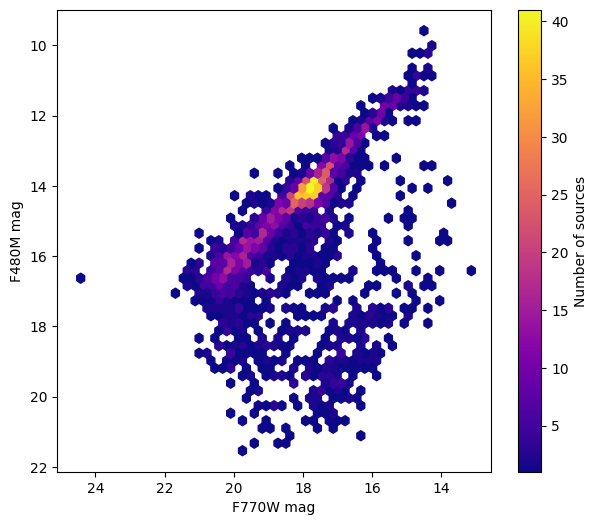

In [ ]:
x = new_cat['aper_total_abmag770']
y = new_cat['mag_ab_f480m']

plt.figure(figsize=(7, 6))
hb = plt.hexbin(
    x, y,
    gridsize=50,        
    cmap='plasma',
    mincnt=1            
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.colorbar(hb, label='Number of sources')
plt.xlabel('F770W mag')
plt.ylabel('F480M mag')
plt.show()


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          2.,  26.,  51.,  88., 132., 219., 367., 544., 352., 266., 304.,
        304., 121.,  17.,   2.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ,
         6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. , 12.6,
        13.2, 13.8, 14.4, 15. , 15.6, 16.2, 16.8, 17.4, 18. , 18.6, 19.2,
        19.8, 20.4, 21. , 21.6, 22.2, 22.8, 23.4, 24. , 24.6, 25.2, 25.8,
        26.4, 27. , 27.6, 28.2, 28.8, 29.4, 30. ]),
 [<matplotlib.patches.Polygon at 0x150354d7fb90>])

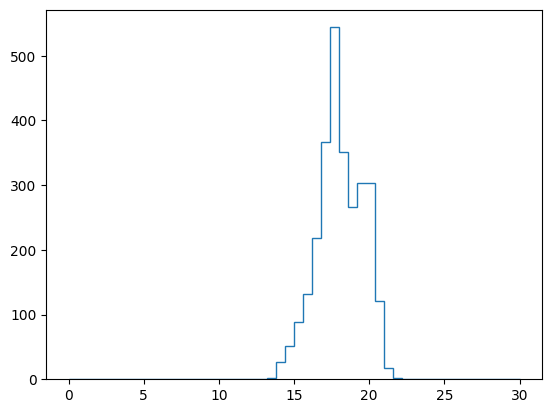

In [10]:
plt.hist(new_cat['aper_total_abmag770'], bins=50, range=(0, 30), histtype='step', label='F770W')

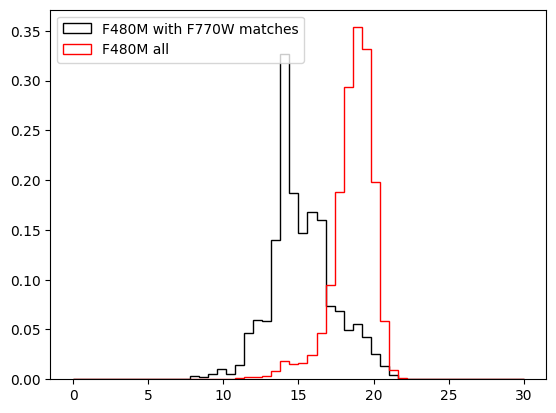

In [14]:
plt.hist(new_cat['mag_ab_f480m'], bins=50, range=(0, 30), histtype='step', color='black', density=True, label = 'F480M with F770W matches')
plt.hist(cat11['mag_ab_f480m'], bins=50, range=(0, 30), histtype='step', color='red', density=True, label = 'F480M all')
plt.legend()